In [ ]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"])

df.head()


,date,surface,playerA,playerB,eloA,eloB,elo_diff,elo_surfaceA,elo_surfaceB,elo_surface_diff,...,rankA,rankB,rank_diff,oddsA,oddsB,pA_market,pB_market,p_diff,logit_pA_market,y
0,2002-06-10,Grass,Johansson T.,Pretzsch A.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,7.0,133.0,-126.0,1.100,6.500,0.855263,0.144737,0.710526,1.776486,1
1,2002-06-10,Grass,Bjorkman J.,Kafelnikov Y.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,56.0,6.0,50.0,2.625,1.444,0.354878,0.645122,-0.290243,-0.597663,0
2,2002-06-10,Grass,Koubek S.,Moya C.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,41.0,20.0,21.0,2.625,1.444,0.354878,0.645122,-0.290243,-0.597663,1
3,2002-06-10,Grass,Pavel A.,Stepanek R.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,21.0,150.0,-129.0,1.533,2.375,0.607728,0.392272,0.215455,0.437770,1
4,2002-06-10,Grass,Stoliarov A.,Sampras P.,1500.0,1500.0,0.0,1500.0,1500.0,0.0,...,107.0,13.0,94.0,5.000,1.143,0.186065,0.813935,-0.627869,-1.475777,0


In [ ]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"])

df.head()


In [5]:
target_col = "y"

meta_cols = ["date", "surface", "playerA", "playerB"]
all_cols = df.columns.tolist()

feature_cols = [c for c in all_cols if c not in meta_cols + [target_col]]

len(feature_cols), feature_cols[:10]


(27,
 ['eloA',
  'eloB',
  'elo_diff',
  'elo_surfaceA',
  'elo_surfaceB',
  'elo_surface_diff',
  'form_winrateA_5',
  'form_winrateB_5',
  'form_winrate_diff_5',
  'form_winrateA_10'])

In [6]:
# 2022 öncesi train, 2022 ve sonrası validation
split_date = pd.Timestamp("2022-01-01")

train_mask = df["date"] < split_date
val_mask = df["date"] >= split_date

train_df = df[train_mask].copy()
val_df = df[val_mask].copy()

len(train_df), len(val_df)


(47879, 10252)

In [7]:
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].copy()


In [9]:
import numpy as np

# Winrate kolonları -> NaN ise 0.5 (tarafsız)
for col in [c for c in X_train.columns if "form_winrate" in c]:
    X_train[col] = X_train[col].fillna(0.5)
    X_val[col] = X_val[col].fillna(0.5)

# days_since_last* kolonları -> NaN ise train medyanı
for col in [c for c in X_train.columns if "days_since_last" in c]:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_val[col] = X_val[col].fillna(median_val)

# Kalan diğer sayısal kolonlar için genel medyan doldurma
for col in X_train.columns:
    if X_train[col].isna().any():
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_val[col] = X_val[col].fillna(median_val)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

logreg = LogisticRegression(max_iter=1000, n_jobs=-1)

logreg.fit(X_train, y_train)

# Olasılıklar
train_proba = logreg.predict_proba(X_train)[:, 1]
val_proba = logreg.predict_proba(X_val)[:, 1]

# Metrikler
train_logloss = log_loss(y_train, train_proba)
val_logloss = log_loss(y_val, val_proba)

train_brier = brier_score_loss(y_train, train_proba)
val_brier = brier_score_loss(y_val, val_proba)

train_acc = accuracy_score(y_train, (train_proba >= 0.5).astype(int))
val_acc = accuracy_score(y_val, (val_proba >= 0.5).astype(int))

train_logloss, val_logloss, train_brier, val_brier, train_acc, val_acc


(0.5698657974172749,
 0.5858829073910039,
 0.19400733897366465,
 0.2012354182820269,
 0.7012468932099668,
 0.6806476785017558)

In [ ]:
import joblib

models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / "logreg_baseline.pkl"
cols_path = models_dir / "feature_columns.txt"

joblib.dump(logreg, model_path)

with open(cols_path, "w") as f:
    for col in feature_cols:
        f.write(col + "\n")
model_path, cols_path

(WindowsPath('C:/Users/alper/predictive-serve/models/logreg_baseline.pkl'),
 WindowsPath('C:/Users/alper/predictive-serve/models/feature_columns.txt'))

In [12]:
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

# Eğitim seti için metrikler
train_logloss = log_loss(y_train, train_proba)
train_brier   = brier_score_loss(y_train, train_proba)
train_acc     = accuracy_score(y_train, (train_proba >= 0.5).astype(int))

# Validation (test) seti için metrikler
val_logloss = log_loss(y_val, val_proba)
val_brier   = brier_score_loss(y_val, val_proba)
val_acc     = accuracy_score(y_val, (val_proba >= 0.5).astype(int))

print("== TRAIN ==")
print(f"Logloss        : {train_logloss:.4f}")
print(f"Brier score    : {train_brier:.4f}")
print(f"Accuracy       : {train_acc*100:.2f}%")

print("\n== VALIDATION ==")
print(f"Logloss        : {val_logloss:.4f}")
print(f"Brier score    : {val_brier:.4f}")
print(f"Accuracy       : {val_acc*100:.2f}%")


== TRAIN ==
Logloss        : 0.5699
Brier score    : 0.1940
Accuracy       : 70.12%

== VALIDATION ==
Logloss        : 0.5859
Brier score    : 0.2012
Accuracy       : 68.06%


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 0/1 sınıf tahminleri
val_pred = (val_proba >= 0.5).astype(int)

cm = confusion_matrix(y_val, val_pred)
print("Confusion Matrix (validation):")
print(cm)

print("\nClassification report:")
print(classification_report(y_val, val_pred, digits=3))


Confusion Matrix (validation):
[[3473 1682]
 [1592 3505]]

Classification report:
              precision    recall  f1-score   support

           0      0.686     0.674     0.680      5155
           1      0.676     0.688     0.682      5097

    accuracy                          0.681     10252
   macro avg      0.681     0.681     0.681     10252
weighted avg      0.681     0.681     0.681     10252



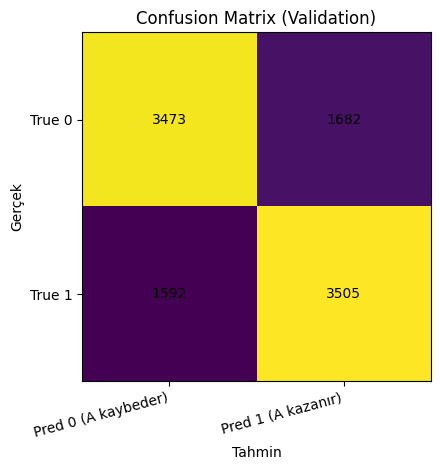

In [14]:
fig, ax = plt.subplots()

im = ax.imshow(cm)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred 0 (A kaybeder)", "Pred 1 (A kazanır)"])
ax.set_yticklabels(["True 0", "True 1"])

plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

ax.set_xlabel("Tahmin")
ax.set_ylabel("Gerçek")
ax.set_title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()


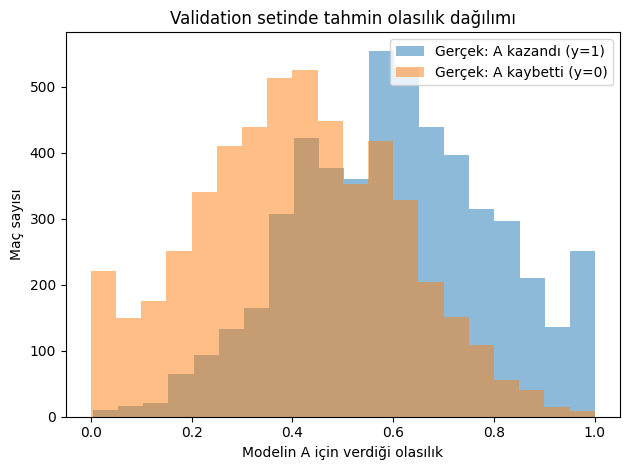

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(val_proba[y_val == 1], bins=20, alpha=0.5, label="Gerçek: A kazandı (y=1)")
ax.hist(val_proba[y_val == 0], bins=20, alpha=0.5, label="Gerçek: A kaybetti (y=0)")

ax.set_xlabel("Modelin A için verdiği olasılık")
ax.set_ylabel("Maç sayısı")
ax.set_title("Validation setinde tahmin olasılık dağılımı")
ax.legend()
plt.tight_layout()
plt.show()


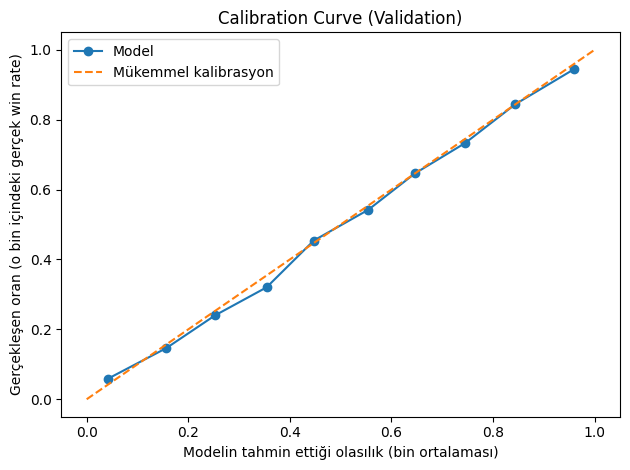

In [16]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, val_proba, n_bins=10, strategy="uniform")

fig, ax = plt.subplots()

ax.plot(prob_pred, prob_true, marker="o", label="Model")
ax.plot([0, 1], [0, 1], linestyle="--", label="Mükemmel kalibrasyon")

ax.set_xlabel("Modelin tahmin ettiği olasılık (bin ortalaması)")
ax.set_ylabel("Gerçekleşen oran (o bin içindeki gerçek win rate)")
ax.set_title("Calibration Curve (Validation)")
ax.legend()
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_eval = pd.DataFrame({"y": y_val, "proba": val_proba})

# Olasılık aralıkları (0-0.1, 0.1-0.2, ...)
bins = np.linspace(0, 1, 11)
val_eval["bin"] = pd.cut(val_eval["proba"], bins=bins, include_lowest=True)

bin_stats = (
    val_eval
    .groupby("bin")
    .agg(
        n_matches=("y", "size"),
        mean_proba=("proba", "mean"),
        true_winrate=("y", "mean")
    )
    .reset_index()
)

bin_stats


C:\Users\alper\AppData\Local\Temp\ipykernel_12792\3034578399.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


,bin,n_matches,mean_proba,true_winrate
0,"(-0.001, 0.1]",394,0.041382,0.058376
1,"(0.1, 0.2]",499,0.156718,0.146293
2,"(0.2, 0.3]",987,0.252819,0.240122
3,"(0.3, 0.4]",1402,0.354191,0.320257
4,"(0.4, 0.5]",1783,0.447292,0.454291
5,"(0.5, 0.6]",1684,0.554403,0.542162
6,"(0.6, 0.7]",1506,0.646067,0.646082
7,"(0.7, 0.8]",976,0.745605,0.733607
8,"(0.8, 0.9]",610,0.843885,0.844262
9,"(0.9, 1.0]",411,0.958938,0.944039


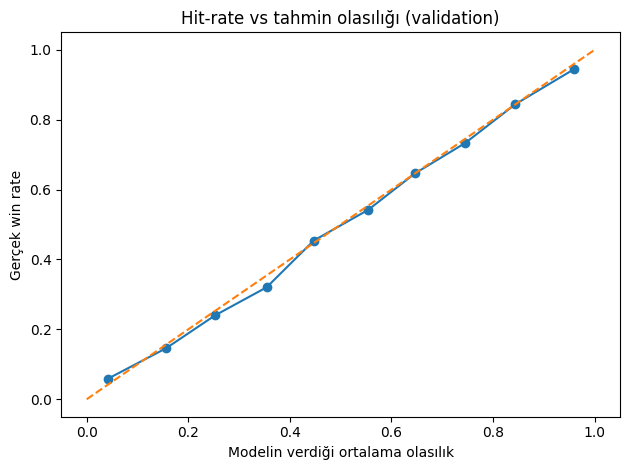

In [18]:
fig, ax = plt.subplots()

ax.plot(bin_stats["mean_proba"], bin_stats["true_winrate"], marker="o")
ax.plot([0, 1], [0, 1], linestyle="--")

ax.set_xlabel("Modelin verdiği ortalama olasılık")
ax.set_ylabel("Gerçek win rate")
ax.set_title("Hit-rate vs tahmin olasılığı (validation)")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# val_df zaten zaman bazlı split'ten geliyordu:
# train_df, val_df = ...

val_eval = val_df.copy()

# Gerçek sonuç (etiket)
val_eval["y"] = y_val.values

# Bizim modelimizin tahmini (p(A kazanır))
val_eval["model_proba"] = val_proba

# Bahis şirketinin tahmini (pA_market: odds'tan gelen probability)
val_eval["market_proba"] = val_eval["pA_market"]

val_eval[["y", "model_proba", "market_proba"]].head()


,y,model_proba,market_proba
47879,1,0.575281,0.588235
47880,1,0.426427,0.411765
47881,0,0.443700,0.430052
47882,0,0.515046,0.526316
47883,1,0.358061,0.343675


In [20]:
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score
import numpy as np

# Model tarafı
model_logloss = log_loss(val_eval["y"], val_eval["model_proba"])
model_brier   = brier_score_loss(val_eval["y"], val_eval["model_proba"])
model_pred    = (val_eval["model_proba"] >= 0.5).astype(int)
model_acc     = accuracy_score(val_eval["y"], model_pred)

# Market tarafı (bahis şirketi)
market_logloss = log_loss(val_eval["y"], val_eval["market_proba"])
market_brier   = brier_score_loss(val_eval["y"], val_eval["market_proba"])
market_pred    = (val_eval["market_proba"] >= 0.5).astype(int)  # 0.5 üstü A favori
market_acc     = accuracy_score(val_eval["y"], market_pred)

results = pd.DataFrame({
    "logloss":  [model_logloss,  market_logloss],
    "brier":    [model_brier,    market_brier],
    "accuracy": [model_acc,      market_acc],
}, index=["Bizim Model", "Bahis Şirketi"])

results


,logloss,brier,accuracy
Bizim Model,0.585883,0.201235,0.680648
Bahis Şirketi,0.585243,0.201148,0.679867


In [21]:
print(f"Bizim model accuracy (validation)  : {model_acc*100:.2f}%")
print(f"Bahis şirketi accuracy (validation): {market_acc*100:.2f}%")


Bizim model accuracy (validation)  : 68.06%
Bahis şirketi accuracy (validation): 67.99%


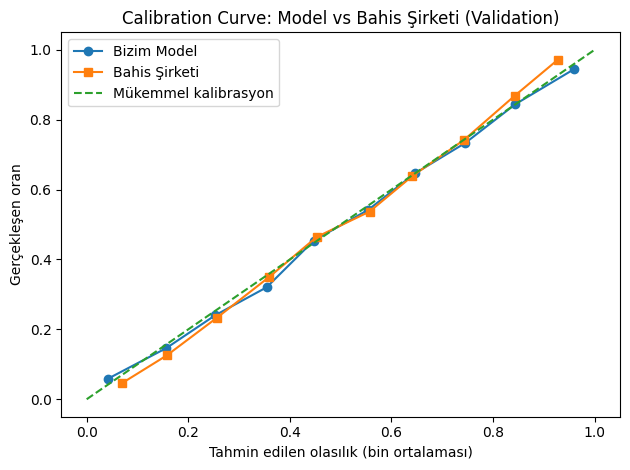

In [22]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Bizim model için calibration
prob_true_model, prob_pred_model = calibration_curve(
    val_eval["y"], val_eval["model_proba"], n_bins=10, strategy="uniform"
)

# Market için calibration
prob_true_market, prob_pred_market = calibration_curve(
    val_eval["y"], val_eval["market_proba"], n_bins=10, strategy="uniform"
)

fig, ax = plt.subplots()

ax.plot(prob_pred_model, prob_true_model, marker="o", label="Bizim Model")
ax.plot(prob_pred_market, prob_true_market, marker="s", label="Bahis Şirketi")
ax.plot([0, 1], [0, 1], linestyle="--", label="Mükemmel kalibrasyon")

ax.set_xlabel("Tahmin edilen olasılık (bin ortalaması)")
ax.set_ylabel("Gerçekleşen oran")
ax.set_title("Calibration Curve: Model vs Bahis Şirketi (Validation)")
ax.legend()
plt.tight_layout()
plt.show()


In [23]:
import numpy as np

# Bin tanımları
bins = np.linspace(0, 1, 11)

val_eval["model_bin"] = pd.cut(val_eval["model_proba"], bins=bins, include_lowest=True)
val_eval["market_bin"] = pd.cut(val_eval["market_proba"], bins=bins, include_lowest=True)

# Bizim model için bin bazlı istatistik
model_bin_stats = (
    val_eval
    .groupby("model_bin")
    .agg(
        n_matches=("y", "size"),
        mean_proba=("model_proba", "mean"),
        true_winrate=("y", "mean"),
    )
    .reset_index()
)

# Market için bin bazlı istatistik
market_bin_stats = (
    val_eval
    .groupby("market_bin")
    .agg(
        n_matches=("y", "size"),
        mean_proba=("market_proba", "mean"),
        true_winrate=("y", "mean"),
    )
    .reset_index()
)

model_bin_stats, market_bin_stats.head()


C:\Users\alper\AppData\Local\Temp\ipykernel_12792\1450487852.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("model_bin")
C:\Users\alper\AppData\Local\Temp\ipykernel_12792\1450487852.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("market_bin")


(       model_bin  n_matches  mean_proba  true_winrate
 0  (-0.001, 0.1]        394    0.041382      0.058376
 1     (0.1, 0.2]        499    0.156718      0.146293
 2     (0.2, 0.3]        987    0.252819      0.240122
 3     (0.3, 0.4]       1402    0.354191      0.320257
 4     (0.4, 0.5]       1783    0.447292      0.454291
 5     (0.5, 0.6]       1684    0.554403      0.542162
 6     (0.6, 0.7]       1506    0.646067      0.646082
 7     (0.7, 0.8]        976    0.745605      0.733607
 8     (0.8, 0.9]        610    0.843885      0.844262
 9     (0.9, 1.0]        411    0.958938      0.944039,
       market_bin  n_matches  mean_proba  true_winrate
 0  (-0.001, 0.1]        219    0.069135      0.045662
 1     (0.1, 0.2]        582    0.157689      0.125430
 2     (0.2, 0.3]       1269    0.255707      0.232467
 3     (0.3, 0.4]       1514    0.359501      0.350066
 4     (0.4, 0.5]       1626    0.452844      0.464330)

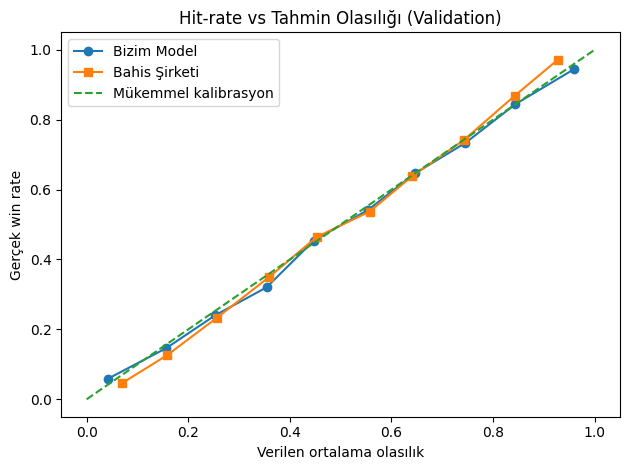

In [24]:
fig, ax = plt.subplots()

ax.plot(model_bin_stats["mean_proba"], model_bin_stats["true_winrate"], marker="o", label="Bizim Model")
ax.plot(market_bin_stats["mean_proba"], market_bin_stats["true_winrate"], marker="s", label="Bahis Şirketi")
ax.plot([0, 1], [0, 1], linestyle="--", label="Mükemmel kalibrasyon")

ax.set_xlabel("Verilen ortalama olasılık")
ax.set_ylabel("Gerçek win rate")
ax.set_title("Hit-rate vs Tahmin Olasılığı (Validation)")
ax.legend()
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# val_df: 2022+ maçlar (zaman bazlı split'ten)
# y_val:  2022+ için gerçek etiketler
# val_proba: 2022+ için model tahminleri

val_eval = val_df.copy()

# Gerçek sonuç
val_eval["y"] = y_val.values

# Bizim modelin olasılığı (p(A kazanır))
val_eval["model_proba"] = val_proba

# Bahis şirketinin olasılığı (pA_market)
val_eval["market_proba"] = val_eval["pA_market"]

val_eval[["date", "y", "model_proba", "market_proba"]].head()


,date,y,model_proba,market_proba
47879,2022-01-03,1,0.575281,0.588235
47880,2022-01-03,1,0.426427,0.411765
47881,2022-01-03,0,0.443700,0.430052
47882,2022-01-03,0,0.515046,0.526316
47883,2022-01-04,1,0.358061,0.343675


In [26]:
years = sorted(val_df["date"].dt.year.unique())
rows = []

for year in years:
    sub = val_eval[val_eval["date"].dt.year == year]
    y_sub = sub["y"]
    mp    = sub["model_proba"]
    mkp   = sub["market_proba"]

    model_acc_y  = accuracy_score(y_sub, (mp  >= 0.5).astype(int))
    market_acc_y = accuracy_score(y_sub, (mkp >= 0.5).astype(int))

    rows.append((year, model_acc_y, market_acc_y))

pd.DataFrame(rows, columns=["year", "model_acc", "market_acc"])


,year,model_acc,market_acc
0,2022,0.679290,0.677318
1,2023,0.677135,0.675220
2,2024,0.689878,0.691020
3,2025,0.675948,0.675545


In [29]:
# 2025'te oynanan tüm validation maçlarını al
val_2025 = val_eval[val_eval["date"].dt.year == 2025].copy()

y_2025            = val_2025["y"]
model_proba_25    = val_2025["model_proba"]
market_proba_25   = val_2025["market_proba"]

len(val_2025), val_2025[["date", "playerA", "playerB"]].head()


(2478,
             date       playerA       playerB
 55653 2025-01-01      Bonzi B.      Jarry N.
 55654 2025-01-01   Thompson J.  Michelsen A.
 55655 2025-01-01   Nishioka Y.    Lehecka J.
 55656 2025-01-01   Dimitrov G.      Vukic A.
 55657 2025-01-01  Khachanov K.  Nishikori K.)

In [30]:
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

# Bizim model (2025)
model_logloss_25 = log_loss(y_2025, model_proba_25)
model_brier_25   = brier_score_loss(y_2025, model_proba_25)
model_acc_25     = accuracy_score(y_2025, (model_proba_25 >= 0.5).astype(int))

# Bahis şirketi (2025)
market_logloss_25 = log_loss(y_2025, market_proba_25)
market_brier_25   = brier_score_loss(y_2025, market_proba_25)
market_acc_25     = accuracy_score(y_2025, (market_proba_25 >= 0.5).astype(int))

print("=== 2025 - Bizim Model ===")
print(f"Logloss : {model_logloss_25:.4f}")
print(f"Brier   : {model_brier_25:.4f}")
print(f"Accuracy: {model_acc_25*100:.2f}%")

print("\n=== 2025 - Bahis Şirketi ===")
print(f"Logloss : {market_logloss_25:.4f}")
print(f"Brier   : {market_brier_25:.4f}")
print(f"Accuracy: {market_acc_25*100:.2f}%")


=== 2025 - Bizim Model ===
Logloss : 0.5940
Brier   : 0.2052
Accuracy: 67.59%

=== 2025 - Bahis Şirketi ===
Logloss : 0.5927
Brier   : 0.2045
Accuracy: 67.55%


In [ ]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
train_path = PROJECT_ROOT / "data" / "processed" / "train_dataset.csv"

df = pd.read_csv(train_path)
df["date"] = pd.to_datetime(df["date"])

df.head()


In [ ]:
target_col = "y"
meta_cols = ["date", "surface", "playerA", "playerB"]

all_cols = df.columns.tolist()
feature_cols = [c for c in all_cols if c not in meta_cols + [target_col]]

len(feature_cols), feature_cols[:15]
